# Create features based on app labels groups

The following feature sets are created:
- ''features_group_app_count.csv': counts of number of unique groups with installed and active devices
- 'features_group_app_installed_count.csv': count of installed apps per group
- 'features_group_app_installed_prop.csv': proportional count of installed apps per group
- 'features_group_app_active_count.csv': count of active apps per group
- 'features_group_app_active_prop.csv': proportional count of active apps per group
- 'features_group_app_active_rel.csv': relative number of active apps over installed apps per group

In [2]:
import os
import math
import re


import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline

dir_in = './data_ori/'
dir_out = './data/'

## Load label categories

In [3]:
# Read app events
labels = pd.read_csv(dir_in + "label_categories.csv")
app_labels = pd.read_csv(dir_in + "app_labels.csv")
apps = pd.merge(app_labels, labels, how='left', on='label_id')
apps['general_groups'] = apps['category']

## Label group definitions

In [4]:
# Group definitions

def to_Games(x):
    # I have gone through 'almost' manually through existing categories and came up with this non-elegant regex
    if re.search('([gG]am)|([pP]oker)|([cC]hess)|([pP]uzz)|([bB]all)|([pP]ursu)|([fF]ight)|([sS]imulat)|([sS]hoot)', 
                 x) is not None:
        return('Games')
    # Then I went through existing abbreviations like RPG, MMO and so on
    if re.search('(RPG)|(SLG)|(RAC)|(MMO)|(MOBA)', x) is not None:
        return('Games')
    # Still small list of items left which is not covered by regex
    if x in ['billards', 'World of Warcraft', 'Tower Defense', 'Tomb', 'Ninja', 'Europe and Fantasy', 'Senki', 
             'Shushan', 'Lottery ticket', 'majiang', 'tennis', 'Martial arts']:
        return('Games')
    else:
        return(x)
    
def to_Property(x):
    # All property/estate stuff will be place into Property category
    if x in ['Property Industry 2.0', 'Property Industry new', 'Property Industry 1.0']:
        return('Property')
    if re.search('([eE]state)', x) is not None:
        return('Property')
    else:
        return(x)
    
def to_Family(x):
    if re.search('([fF]amili)|([mM]othe)|([fF]athe)|(bab)|([rR]elative)|([pP]regnan)|([pP]arent)|([mM]arriag)|([lL]ove)',
                 x) is not None:
        return('Family')
    else:
        return(x)
    
def to_Fun(x):
    '''One can argue about my decision however I used following rules:
       - all comics -> Fun
       - all animation/painting -> Fun
       - all things labeled as trend or passion or community -> Fun
       - all things I could identify as messangers -> Fun
       - all things related to images/pictures -> Fun
       - horoscopes -> Fun
       - jokes -> Fun
       - I don\'t know what is Parkour avoid but it goes to -> Fun''' 
    if re.search('([fF]un)|([cC]ool)|([tT]rend)|([cC]omic)|([aA]nima)|([pP]ainti)|\
                 ([fF]iction)|([pP]icture)|(joke)|([hH]oroscope)|([pP]assion)|([sS]tyle)|\
                 ([cC]ozy)|([bB]log)', x) is not None:
        return('Fun')
    if x in ['Parkour avoid class', 'community', 'Enthusiasm', 'cosplay', 'IM']:
        return('Fun')
    else:
        return(x)
    
def to_Productivity(x):
    if x == 'Personal Effectiveness 1' or x == 'Personal Effectiveness':
        return('Productivity')
    else:
        return(x)
    
def to_Finance(x):
    if re.search('([iI]ncome)|([pP]rofitabil)|([lL]iquid)|([rR]isk)|([bB]ank)|([fF]uture)|([fF]und)|([sS]tock)|([sS]hare)',
                 x) is not None:
        return('Finance')
    if re.search('([fF]inanc)|([pP]ay)|(P2P)|([iI]nsura)|([lL]oan)|([cC]ard)|([mM]etal)|\
                  ([cC]ost)|([wW]ealth)|([bB]roker)|([bB]usiness)|([eE]xchange)', x) is not None:
        return('Finance')
    if x in ['High Flow', 'Housekeeping', 'Accounting', 'Debit and credit', 'Recipes', 'Heritage Foundation', 'IMF',]:
        return('Finance')
    else:
        return(x)
    
def to_Religion(x):
    if x == 'And the Church':
        return('Religion')
    else:
        return(x)

def to_Services(x):
    if re.search('([sS]ervice)', x) is not None:
        return('Services')
    else:
        return(x)
    
def to_Travel(x):
    if re.search('([aA]viation)|([aA]irlin)|([bB]ooki)|([tT]ravel)|\
                  ([hH]otel)|([tT]rain)|([tT]axi)|([rR]eservati)|([aA]ir)|([aA]irport)', x) is not None:
        return('Travel')
    if re.search('([jJ]ourne)|([tT]ransport)|([aA]ccommodat)|([nN]avigat)|([tT]ouris)|([fF]light)|([bB]us)', x) is not None:
        return('Travel')
    if x in ['High mobility', 'Destination Region', 'map', 'Weather', 'Rentals']:
        return('Travel')
    else:
        return(x)
    
def to_Custom(x):
    if re.search('([cC]ustom)', x) is not None:
        return('Custom')
    else:
        return(x)
    
def to_Video(x):
    # not sure if round means Rounds app for group chat, but I stick to this hypothesis. Might be popular app in China
    if x in ['video', 'round', 'the film', 'movie']:
        return('Video')
    else:
        return(x)
    
def to_Shopping(x):
    if x in ['Smart Shopping', 'online malls', 'online shopping by group, like groupon', 'takeaway ordering', 
             'online shopping, price comparing', 'Buy class', 'Buy', 'shopping sharing',
             'Smart Shopping 1', 'online shopping navigation']:
        return('Shopping')
    else:
        return(x)
    
def to_Education(x):
    if re.search('([eE]ducati)|([rR]ead)|([sS]cienc)|([bB]ooks)', x) is not None:
        return('Education')
    if x in ['literature', 'Maternal and child population', 'psychology', 'exams', 'millitary and wars', 'news', 
             'foreign language', 'magazine and journal', 'dictionary', 'novels', 'art and culture', 'Entertainment News', 
             'College Students', 'math', 'Western Mythology', 'Technology Information', 'study abroad', 
             'Chinese Classical Mythology']:
        return('Education')
    else:
        return(x)
    
def to_Vitality(x):
    if x in ['vitality', '1 vitality']:
        return('Vitality')
    if x in [ 'sports and gym', 'Health Management', 'Integrated Living', 'Medical', 'Free exercise', 'A beauty care', 
             'fashion', 'fashion outfit', 'lose weight', 'health', 'Skin care applications', 'Wearable Health']:
        return('Vitality')
    else:
        return(x)
    
def to_Sports(x):
    if x in ['sports', 'Sports News']:
        return('Sports')
    else:
        return(x)
    
def to_Music(x):
    if x == 'music':
        return('Music')
    else:
        return(x)
    
def to_Travel_2(x):
    if re.search('([hH]otel)', x) is not None:
        return('Travel')
    else:
        return(x)
    
def to_Other(x):
    if x in ['1 free',
 'The elimination of class',
 'unknown',
 'free',
 'comfortable',
 'Cozy 1',
 'other',
 'Total Cost 1',
 'Classical 1',
 'Quality 1',
 'classical',
 'quality',
 'Car Owners',
 'Noble 1',
 'Pirated content',
 'Securities',
 'professional skills',
 'Jobs',
 'Reputation',
 'Simple 1',
 '1 reputation',
 'Condition of the vehicles',
 'magic',
 'Internet Securities',
 'weibo',
 'Housing Advice',
 'notes',
 'farm',
 'Nature 1',
 'Total Cost',
 'Sea Amoy',
 'show',
 'Car',
 'pet raising up',
 'dotal-lol',
 'Express',
 'radio',
 'Occupational identity',
 'Utilities',
 'Trust',
 'Contacts',
 'Simple',
 'Automotive News',
 'Sale of cars',
 'File Editor',
 'network disk',
 'class managemetn',
 'management',
 'natural',
 'Points Activities',
 'Decoration',
 'store management',
 'Maternal and child supplies',
 'Tour around',
 'coupon',
 'User Community',
 'Vermicelli',
 'noble',
 'poetry',
 'Antique collection',
 'Reviews',
 'Scheduling',
 'Beauty Nail',
 'shows',
 'Hardware Related',
 'Smart Home',
 'Sellers',
 'Desktop Enhancements',
 'library',
 'entertainment',
 'Calendar',
 'Ping',
 'System Tools',
 'KTV',
 'Behalf of the drive',
 'household products',
 'Information',
 'Man playing favorites',
 'App Store',
 'Engineering Drawing',
 'Academic Information',
 'Appliances',
 'Peace - Search',
 'Make-up application',
 'WIFI',
 'phone',
 'Doctors',
 'Smart Appliances',
 'reality show',
 'Harem',
 'trickery',
 'Jin Yong',
 'effort',
 'Xian Xia',
 'Romance',
 'tribe',
 'email',
 'mesasge',
 'Editor',
 'Clock',
 'search',
 'Intelligent hardware',
 'Browser',
 'Furniture']:
        return('Other')
    else:
        return(x)

In [5]:
apps['general_groups'] = apps['general_groups'].apply(to_Games)
apps['general_groups'] = apps['general_groups'].apply(to_Property)
apps['general_groups'] = apps['general_groups'].apply(to_Family)
apps['general_groups'] = apps['general_groups'].apply(to_Fun)
apps['general_groups'] = apps['general_groups'].apply(to_Productivity)
apps['general_groups'] = apps['general_groups'].apply(to_Finance)
apps['general_groups'] = apps['general_groups'].apply(to_Religion)
apps['general_groups'] = apps['general_groups'].apply(to_Services)
apps['general_groups'] = apps['general_groups'].apply(to_Travel)
apps['general_groups'] = apps['general_groups'].apply(to_Custom)
apps['general_groups'] = apps['general_groups'].apply(to_Video)
apps['general_groups'] = apps['general_groups'].apply(to_Shopping)
apps['general_groups'] = apps['general_groups'].apply(to_Education)
apps['general_groups'] = apps['general_groups'].apply(to_Vitality)
apps['general_groups'] = apps['general_groups'].apply(to_Sports)
apps['general_groups'] = apps['general_groups'].apply(to_Music)
apps['general_groups'] = apps['general_groups'].apply(to_Travel_2)
apps['general_groups'] = apps['general_groups'].apply(to_Sports)
apps['general_groups'] = apps['general_groups'].apply(to_Other)

In [6]:
apps.head()

,app_id,label_id,category,general_groups
0,7324884708820027918,251,Finance,Finance
1,-4494216993218550286,251,Finance,Finance
2,6058196446775239644,406,unknown,Other
3,6058196446775239644,407,DS_P2P net loan,Finance
4,8694625920731541625,406,unknown,Other


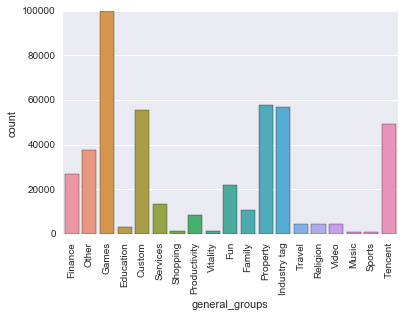

In [7]:
sns.countplot(x='general_groups', data=apps)
plt.xticks(rotation=90)
sns.plt.show()

## Merge with app events

In [8]:
app_events = pd.read_csv(dir_in + 'app_events.csv')

In [9]:
app_events = app_events.merge(apps, on='app_id', how='left')

In [10]:
app_events.head()

,event_id,app_id,is_installed,is_active,label_id,category,general_groups
0,2,5927333115845830913,1,1,549,Property Industry 1.0,Property
1,2,5927333115845830913,1,1,710,Relatives 1,Family
2,2,5927333115845830913,1,1,704,Property Industry 2.0,Property
3,2,5927333115845830913,1,1,548,Industry tag,Industry tag
4,2,5927333115845830913,1,1,172,IM,Fun


In [11]:
group_count = app_events.groupby(['event_id','general_groups'])['is_installed', 'is_active'].sum().reset_index()

In [12]:
group_cols = apps.general_groups.unique()
print group_cols

['Finance' 'Other' 'Games' 'Education' 'Custom' 'Services' 'Shopping'
 'Productivity' 'Vitality' 'Fun' 'Family' 'Property' 'Industry tag'
 'Travel' 'Religion' 'Video' 'Music' 'Sports' 'Tencent']


In [13]:
print group_count.shape
group_count.head()

(18457719, 4)


,event_id,general_groups,is_installed,is_active
0,2,Custom,7,3
1,2,Family,3,2
2,2,Finance,57,25
3,2,Fun,2,2
4,2,Games,1,0


In [14]:
group_installed = group_count.groupby(['event_id','general_groups']).is_installed.mean().unstack('general_groups').reset_index()
group_installed.head()

general_groups,event_id,Custom,Education,Family,Finance,Fun,Games,Industry tag,Music,Other,Productivity,Property,Religion,Services,Shopping,Sports,Tencent,Travel,Video,Vitality
0,2,7.0,NaN,3.0,57.0,2.0,1.0,16.0,NaN,10.0,4.0,23.0,7.0,5.0,2.0,NaN,NaN,6.0,NaN,1.0
1,6,12.0,10.0,2.0,63.0,8.0,2.0,24.0,1.0,32.0,5.0,31.0,7.0,8.0,6.0,NaN,3.0,5.0,3.0,NaN
2,7,21.0,8.0,1.0,185.0,4.0,8.0,30.0,NaN,21.0,8.0,38.0,20.0,18.0,1.0,NaN,NaN,3.0,1.0,1.0
3,9,13.0,6.0,4.0,113.0,3.0,10.0,26.0,2.0,24.0,4.0,32.0,11.0,7.0,1.0,NaN,1.0,2.0,3.0,NaN
4,16,9.0,4.0,3.0,68.0,1.0,5.0,23.0,1.0,32.0,3.0,33.0,8.0,11.0,2.0,NaN,NaN,2.0,3.0,3.0


In [15]:
group_active = group_count.groupby(['event_id','general_groups']).is_active.mean().unstack('general_groups').reset_index()
group_active.head()

general_groups,event_id,Custom,Education,Family,Finance,Fun,Games,Industry tag,Music,Other,Productivity,Property,Religion,Services,Shopping,Sports,Tencent,Travel,Video,Vitality
0,2,3.0,NaN,2.0,25.0,2.0,0.0,5.0,NaN,0.0,0.0,9.0,3.0,3.0,0.0,NaN,NaN,0.0,NaN,0.0
1,6,4.0,3.0,2.0,20.0,4.0,1.0,10.0,0.0,12.0,1.0,15.0,2.0,4.0,2.0,NaN,1.0,1.0,1.0,NaN
2,7,6.0,1.0,1.0,58.0,1.0,0.0,10.0,NaN,7.0,1.0,14.0,6.0,6.0,0.0,NaN,NaN,1.0,0.0,0.0
3,9,1.0,1.0,2.0,8.0,1.0,0.0,6.0,0.0,2.0,2.0,9.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN
4,16,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [16]:
del app_events

## Merge with events

In [17]:
events = pd.read_csv(dir_in + 'events.csv').drop(['timestamp','longitude','latitude'], axis=1)

In [18]:
group_installed = group_installed.merge(events, on='event_id', how='left') \
                           .groupby('device_id') \
                           .sum() \
                           .drop(['event_id'], axis=1).reset_index()
group_installed['group_total_installed'] = group_installed.iloc[:,1:].sum(axis=1)
group_active = group_active.merge(events, on='event_id', how='left') \
                           .groupby('device_id') \
                           .sum() \
                           .drop(['event_id'], axis=1).reset_index()
group_active['group_total_active'] = group_active.iloc[:,1:].sum(axis=1)

In [19]:
group_installed.head()

general_groups,device_id,Custom,Education,Family,Finance,Fun,Games,Industry tag,Music,Other,...,Property,Religion,Services,Shopping,Sports,Tencent,Travel,Video,Vitality,group_total_installed
0,-9222956879900151005,671.0,66.0,59.0,7550.0,121.0,56.0,1373.0,NaN,444.0,...,759.0,644.0,228.0,NaN,NaN,NaN,57.0,NaN,NaN,12117.0
1,-9222661944218806987,11.0,NaN,13.0,48.0,26.0,10.0,64.0,6.0,31.0,...,85.0,6.0,21.0,10.0,NaN,5.0,NaN,NaN,38.0,377.0
2,-9222399302879214035,118.0,54.0,90.0,738.0,72.0,90.0,288.0,NaN,373.0,...,378.0,73.0,117.0,90.0,NaN,27.0,162.0,17.0,27.0,2759.0
3,-9221825537663503111,111.0,NaN,86.0,629.0,237.0,105.0,327.0,NaN,179.0,...,361.0,51.0,102.0,10.0,NaN,45.0,30.0,83.0,10.0,2381.0
4,-9221767098072603291,20.0,66.0,16.0,128.0,21.0,23.0,125.0,6.0,159.0,...,164.0,14.0,28.0,20.0,NaN,6.0,NaN,7.0,22.0,848.0


In [20]:
group_active.head()

general_groups,device_id,Custom,Education,Family,Finance,Fun,Games,Industry tag,Music,Other,...,Property,Religion,Services,Shopping,Sports,Tencent,Travel,Video,Vitality,group_total_active
0,-9222956879900151005,277.0,64.0,51.0,3139.0,79.0,31.0,680.0,NaN,296.0,...,505.0,253.0,137.0,NaN,NaN,NaN,37.0,NaN,NaN,5622.0
1,-9222661944218806987,3.0,NaN,8.0,16.0,17.0,2.0,46.0,6.0,17.0,...,61.0,2.0,20.0,6.0,NaN,1.0,NaN,NaN,35.0,243.0
2,-9222399302879214035,8.0,2.0,6.0,70.0,2.0,0.0,4.0,NaN,40.0,...,8.0,8.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,150.0
3,-9221825537663503111,20.0,NaN,63.0,270.0,75.0,14.0,200.0,NaN,60.0,...,227.0,19.0,81.0,10.0,NaN,1.0,1.0,45.0,10.0,1096.0
4,-9221767098072603291,13.0,13.0,16.0,100.0,16.0,6.0,69.0,3.0,68.0,...,93.0,11.0,20.0,17.0,NaN,2.0,NaN,2.0,20.0,478.0


## Merge with train for validation

In [21]:
train = pd.read_csv(dir_in + 'gender_age_train.csv')

In [22]:
train_gi = train.merge(group_installed, how='inner')
train_ga = train.merge(group_active, how='inner')

In [23]:
print train_gi.shape
train_gi.head()

(23290, 24)


,device_id,gender,age,group,Custom,Education,Family,Finance,Fun,Games,...,Property,Religion,Services,Shopping,Sports,Tencent,Travel,Video,Vitality,group_total_installed
0,-8260683887967679142,M,35,M32-38,8.0,13.0,14.0,30.0,18.0,3.0,...,45.0,3.0,13.0,6.0,NaN,2.0,25.0,9.0,2.0,275.0
1,7477216237379271436,F,37,F33-42,9.0,6.0,6.0,83.0,19.0,3.0,...,83.0,9.0,22.0,4.0,NaN,NaN,27.0,4.0,5.0,409.0
2,6352067998666467520,M,32,M32-38,57.0,5.0,22.0,328.0,32.0,17.0,...,138.0,52.0,37.0,NaN,NaN,NaN,23.0,7.0,NaN,955.0
3,1508636020748379883,F,28,F27-28,19.0,12.0,44.0,75.0,37.0,NaN,...,131.0,10.0,25.0,9.0,NaN,4.0,NaN,NaN,5.0,558.0
4,-6876541075223249434,M,75,M39+,70.0,65.0,16.0,376.0,52.0,56.0,...,344.0,40.0,111.0,46.0,NaN,16.0,86.0,27.0,30.0,1897.0


In [24]:
print train_ga.shape
train_ga.head()

(23290, 24)


,device_id,gender,age,group,Custom,Education,Family,Finance,Fun,Games,...,Property,Religion,Services,Shopping,Sports,Tencent,Travel,Video,Vitality,group_total_active
0,-8260683887967679142,M,35,M32-38,0.0,1.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0,0.0,24.0
1,7477216237379271436,F,37,F33-42,3.0,0.0,4.0,29.0,14.0,0.0,...,46.0,3.0,16.0,1.0,NaN,NaN,3.0,1.0,2.0,174.0
2,6352067998666467520,M,32,M32-38,41.0,2.0,22.0,223.0,24.0,4.0,...,96.0,39.0,31.0,NaN,NaN,NaN,15.0,4.0,NaN,675.0
3,1508636020748379883,F,28,F27-28,10.0,0.0,23.0,38.0,18.0,NaN,...,72.0,5.0,13.0,4.0,NaN,0.0,NaN,NaN,4.0,283.0
4,-6876541075223249434,M,75,M39+,12.0,7.0,6.0,76.0,9.0,4.0,...,94.0,9.0,25.0,7.0,NaN,2.0,27.0,3.0,7.0,422.0


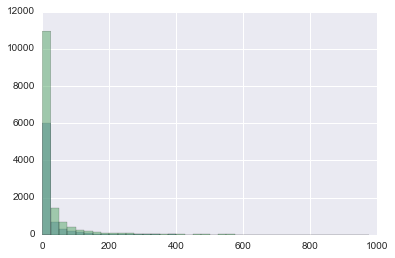

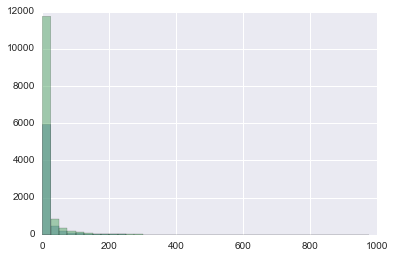

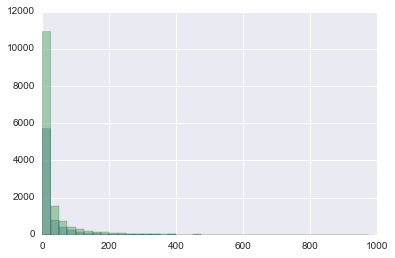

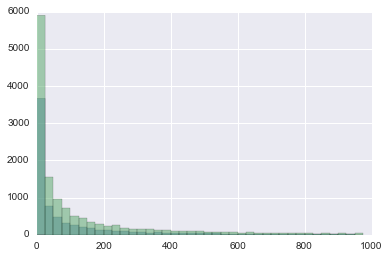

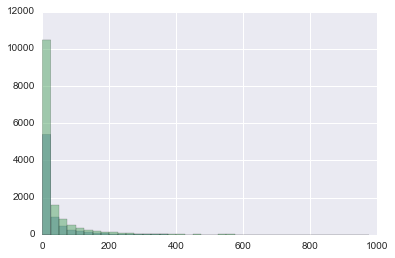

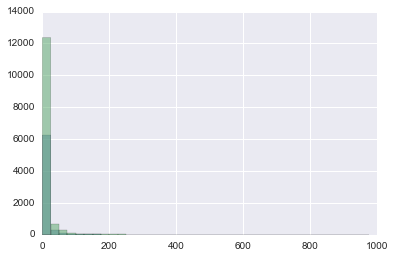

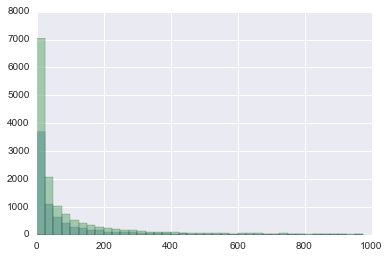

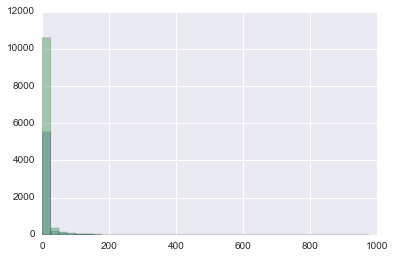

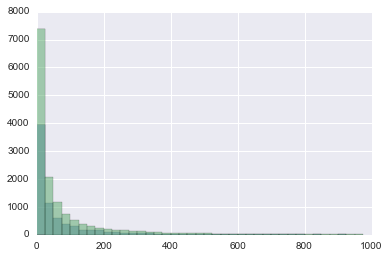

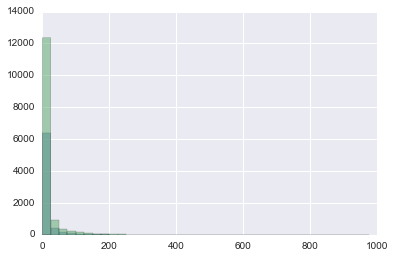

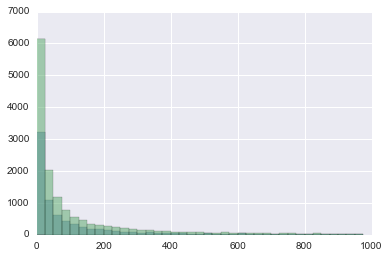

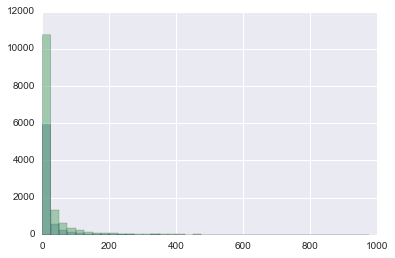

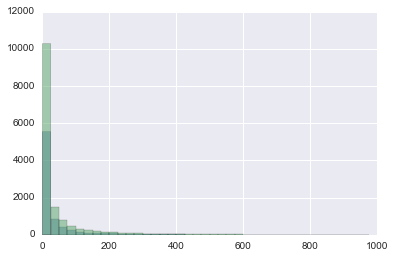

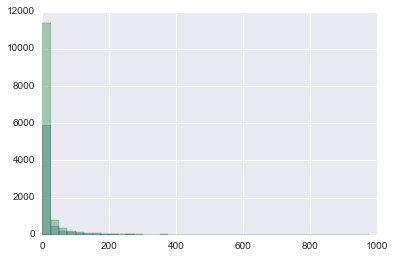

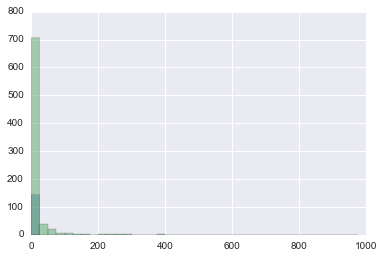

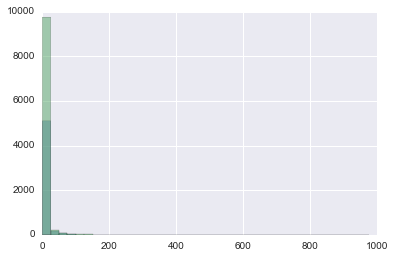

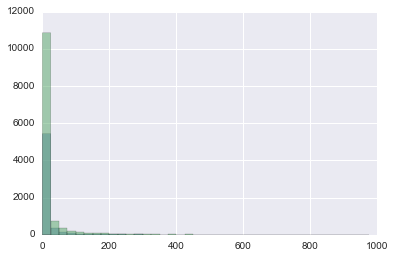

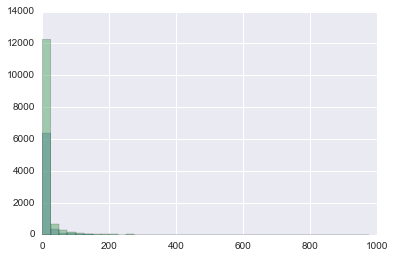

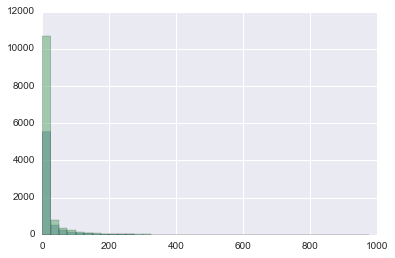

In [25]:
for c in train_ga.columns[4:-1]:
    f, ax = plt.subplots()
    bins = np.arange(0,1000,25)
    train_ga[train_ga.gender=='F'][c].hist(ax=ax, bins=bins, alpha=0.5)
    train_ga[train_ga.gender=='M'][c].hist(ax=ax, bins=bins, alpha=0.5)

In [26]:
rel = train_ga.groupby('group').mean().iloc[:,4:-1].div(train_ga.groupby('group').mean().group_total_active, axis=0)

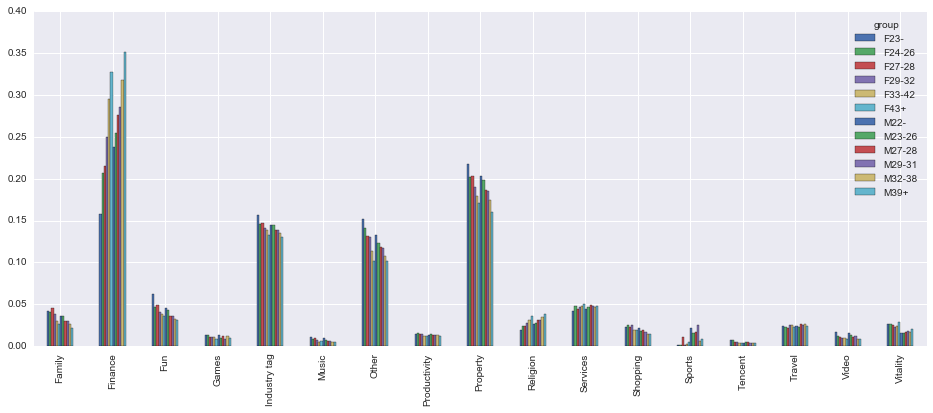

In [27]:
rel.T.plot(kind='bar', figsize=(16,6))

In [28]:
rel = train_gi.groupby('group').mean().iloc[:,4:-1].div(train_gi.groupby('group').mean().group_total_installed, axis=0)

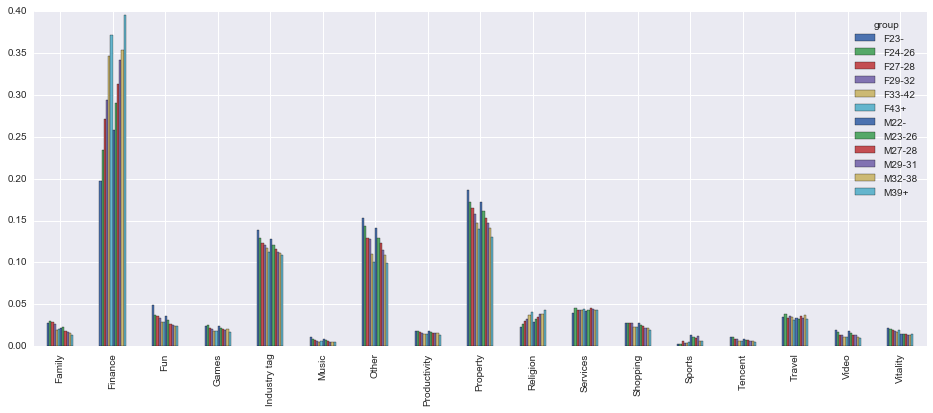

In [29]:
rel.T.plot(kind='bar', figsize=(16,6))

## Save to features files
Five features files are created:
- Per device ID number of unique groups installed and number of unique groups active
- Per device ID for each app group number of apps installed
- Per device ID for each app group proportional number of installed apps
- Per device ID for each app group number of apps active
- Per device ID for each app group proportional number of active apps
- Per device ID for each app group relative number of active apps

In [30]:
group_installed.set_index('device_id', inplace=True)
group_active.set_index('device_id', inplace=True)

In [31]:
group_installed.fillna(0, inplace=True)
group_active.fillna(0, inplace=True)

### Unique group count

In [32]:
feature_file = 'features_group_app_count.csv'
df = group_installed
df['n_unique_groups_with_installed_apps'] = (group_installed[group_cols]>0).sum(axis=1)
df['n_unique_groups_with_active_apps'] = (group_active[group_cols]>0).sum(axis=1)
df = df[['n_unique_groups_with_installed_apps','n_unique_groups_with_active_apps']]

In [33]:
df.head()

general_groups,n_unique_groups_with_installed_apps,n_unique_groups_with_active_apps
device_id,,
-9222956879900151005,13,13
-9222661944218806987,15,15
-9222399302879214035,17,10
-9221825537663503111,16,15
-9221767098072603291,17,17


In [34]:
df.to_csv(dir_out+feature_file)

### Apps installed count

In [35]:
feature_file = 'features_group_app_installed_count.csv'
df = group_installed[group_cols]

In [36]:
df.head()

general_groups,Finance,Other,Games,Education,Custom,Services,Shopping,Productivity,Vitality,Fun,Family,Property,Industry tag,Travel,Religion,Video,Music,Sports,Tencent
device_id,,,,,,,,,,,,,,,,,,,
-9222956879900151005,7550.0,444.0,56.0,66.0,671.0,228.0,0.0,89.0,0.0,121.0,59.0,759.0,1373.0,57.0,644.0,0.0,0.0,0.0,0.0
-9222661944218806987,48.0,31.0,10.0,0.0,11.0,21.0,10.0,3.0,38.0,26.0,13.0,85.0,64.0,0.0,6.0,0.0,6.0,0.0,5.0
-9222399302879214035,738.0,373.0,90.0,54.0,118.0,117.0,90.0,45.0,27.0,72.0,90.0,378.0,288.0,162.0,73.0,17.0,0.0,0.0,27.0
-9221825537663503111,629.0,179.0,105.0,0.0,111.0,102.0,10.0,15.0,10.0,237.0,86.0,361.0,327.0,30.0,51.0,83.0,0.0,0.0,45.0
-9221767098072603291,128.0,159.0,23.0,66.0,20.0,28.0,20.0,23.0,22.0,21.0,16.0,164.0,125.0,0.0,14.0,7.0,6.0,0.0,6.0


In [37]:
df.to_csv(dir_out+feature_file)

### Apps active propertional

In [38]:
feature_file = 'features_group_app_installed_prop.csv'
df = group_installed[group_cols].div(group_installed['group_total_installed'], axis=0)

In [39]:
df.head()

general_groups,Finance,Other,Games,Education,Custom,Services,Shopping,Productivity,Vitality,Fun,Family,Property,Industry tag,Travel,Religion,Video,Music,Sports,Tencent
device_id,,,,,,,,,,,,,,,,,,,
-9222956879900151005,0.623092,0.036643,0.004622,0.005447,0.055377,0.018817,0.000000,0.007345,0.000000,0.009986,0.004869,0.062639,0.113312,0.004704,0.053148,0.000000,0.000000,0.0,0.000000
-9222661944218806987,0.127321,0.082228,0.026525,0.000000,0.029178,0.055703,0.026525,0.007958,0.100796,0.068966,0.034483,0.225464,0.169761,0.000000,0.015915,0.000000,0.015915,0.0,0.013263
-9222399302879214035,0.267488,0.135194,0.032621,0.019572,0.042769,0.042407,0.032621,0.016310,0.009786,0.026096,0.032621,0.137006,0.104386,0.058717,0.026459,0.006162,0.000000,0.0,0.009786
-9221825537663503111,0.264175,0.075178,0.044099,0.000000,0.046619,0.042839,0.004200,0.006300,0.004200,0.099538,0.036119,0.151617,0.137337,0.012600,0.021420,0.034859,0.000000,0.0,0.018900
-9221767098072603291,0.150943,0.187500,0.027123,0.077830,0.023585,0.033019,0.023585,0.027123,0.025943,0.024764,0.018868,0.193396,0.147406,0.000000,0.016509,0.008255,0.007075,0.0,0.007075


In [40]:
df.to_csv(dir_out+feature_file)

### Apps active count


In [41]:
feature_file = 'features_group_app_active_count.csv'
df = group_active[group_cols]
df.head()

general_groups,Finance,Other,Games,Education,Custom,Services,Shopping,Productivity,Vitality,Fun,Family,Property,Industry tag,Travel,Religion,Video,Music,Sports,Tencent
device_id,,,,,,,,,,,,,,,,,,,
-9222956879900151005,3139.0,296.0,31.0,64.0,277.0,137.0,0.0,73.0,0.0,79.0,51.0,505.0,680.0,37.0,253.0,0.0,0.0,0.0,0.0
-9222661944218806987,16.0,17.0,2.0,0.0,3.0,20.0,6.0,3.0,35.0,17.0,8.0,61.0,46.0,0.0,2.0,0.0,6.0,0.0,1.0
-9222399302879214035,70.0,40.0,0.0,2.0,8.0,2.0,0.0,0.0,0.0,2.0,6.0,8.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0
-9221825537663503111,270.0,60.0,14.0,0.0,20.0,81.0,10.0,0.0,10.0,75.0,63.0,227.0,200.0,1.0,19.0,45.0,0.0,0.0,1.0
-9221767098072603291,100.0,68.0,6.0,13.0,13.0,20.0,17.0,9.0,20.0,16.0,16.0,93.0,69.0,0.0,11.0,2.0,3.0,0.0,2.0


In [42]:
df.to_csv(dir_out+feature_file)

### Apps active propertional

In [43]:
feature_file = 'features_group_app_active_prop.csv'
df = group_active[group_cols].div(group_active.group_total_active, axis=0)
df.fillna(0, inplace=True)
df.head()

general_groups,Finance,Other,Games,Education,Custom,Services,Shopping,Productivity,Vitality,Fun,Family,Property,Industry tag,Travel,Religion,Video,Music,Sports,Tencent
device_id,,,,,,,,,,,,,,,,,,,
-9222956879900151005,0.558342,0.052650,0.005514,0.011384,0.049271,0.024369,0.000000,0.012985,0.000000,0.014052,0.009072,0.089826,0.120953,0.006581,0.045002,0.000000,0.000000,0.0,0.000000
-9222661944218806987,0.065844,0.069959,0.008230,0.000000,0.012346,0.082305,0.024691,0.012346,0.144033,0.069959,0.032922,0.251029,0.189300,0.000000,0.008230,0.000000,0.024691,0.0,0.004115
-9222399302879214035,0.466667,0.266667,0.000000,0.013333,0.053333,0.013333,0.000000,0.000000,0.000000,0.013333,0.040000,0.053333,0.026667,0.000000,0.053333,0.000000,0.000000,0.0,0.000000
-9221825537663503111,0.246350,0.054745,0.012774,0.000000,0.018248,0.073905,0.009124,0.000000,0.009124,0.068431,0.057482,0.207117,0.182482,0.000912,0.017336,0.041058,0.000000,0.0,0.000912
-9221767098072603291,0.209205,0.142259,0.012552,0.027197,0.027197,0.041841,0.035565,0.018828,0.041841,0.033473,0.033473,0.194561,0.144351,0.000000,0.023013,0.004184,0.006276,0.0,0.004184


In [44]:
df.to_csv(dir_out+feature_file)

### Relative number of active apps

In [45]:
feature_file = 'features_group_app_active_rel.csv'
df = group_active[group_cols].div(group_installed[group_cols])
df.fillna(0, inplace=True)
df.head()

general_groups,Finance,Other,Games,Education,Custom,Services,Shopping,Productivity,Vitality,Fun,Family,Property,Industry tag,Travel,Religion,Video,Music,Sports,Tencent
device_id,,,,,,,,,,,,,,,,,,,
-9222956879900151005,0.415762,0.666667,0.553571,0.969697,0.412817,0.600877,0.00,0.820225,0.000000,0.652893,0.864407,0.665349,0.495266,0.649123,0.392857,0.000000,0.0,0.0,0.000000
-9222661944218806987,0.333333,0.548387,0.200000,0.000000,0.272727,0.952381,0.60,1.000000,0.921053,0.653846,0.615385,0.717647,0.718750,0.000000,0.333333,0.000000,1.0,0.0,0.200000
-9222399302879214035,0.094851,0.107239,0.000000,0.037037,0.067797,0.017094,0.00,0.000000,0.000000,0.027778,0.066667,0.021164,0.013889,0.000000,0.109589,0.000000,0.0,0.0,0.000000
-9221825537663503111,0.429253,0.335196,0.133333,0.000000,0.180180,0.794118,1.00,0.000000,1.000000,0.316456,0.732558,0.628809,0.611621,0.033333,0.372549,0.542169,0.0,0.0,0.022222
-9221767098072603291,0.781250,0.427673,0.260870,0.196970,0.650000,0.714286,0.85,0.391304,0.909091,0.761905,1.000000,0.567073,0.552000,0.000000,0.785714,0.285714,0.5,0.0,0.333333


In [46]:
df.to_csv(dir_out+feature_file)